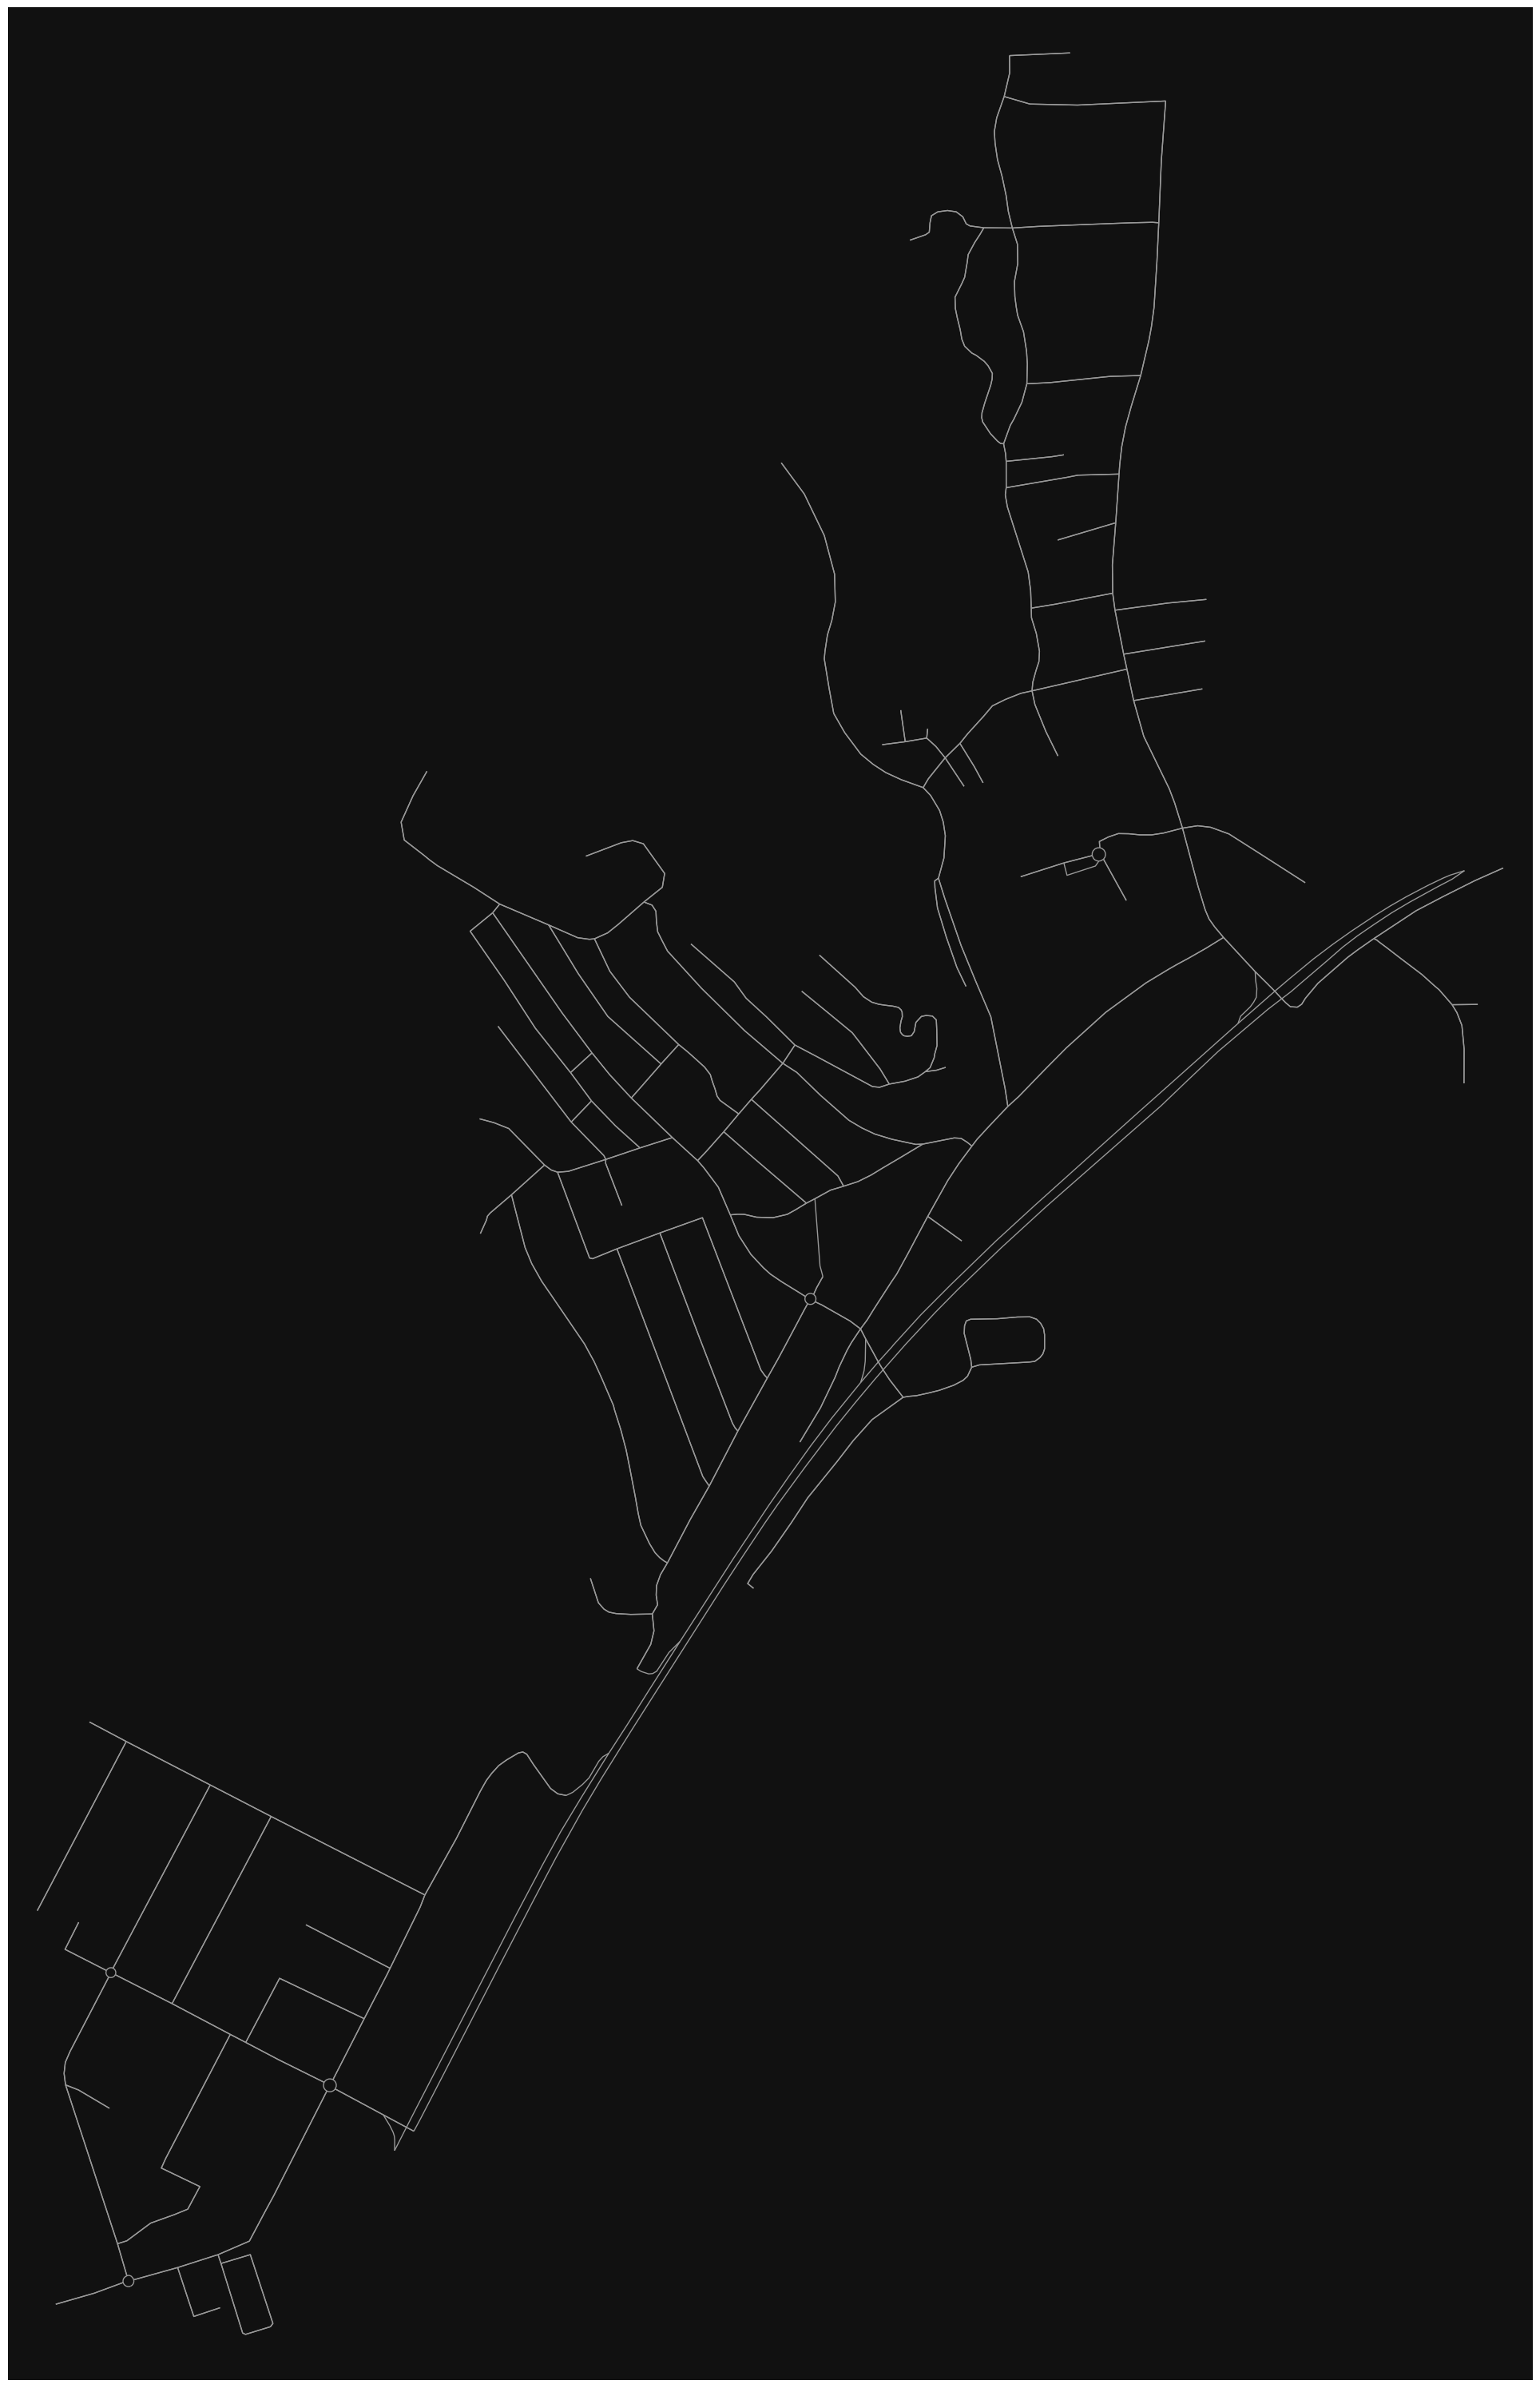

In [3]:
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

G = ox.graph_from_place("Trzin, Slovenia", network_type="drive", simplify="False")
fig, ax = ox.plot_graph(G, figsize=(58.33, 38.57), dpi=100, node_size=0)

In [5]:
# seznam osmnid-jev vozlisc
nodes_list = list(G.nodes)
# seznam povezav in atributov lanes, name, maxspeed, length, noter bomo shranili le enosmerne ceste, po tem ko vse dvosmerne spremenimo v dve enosmerni
edges_list = []

# pretvorimo graf G v dva GeoDataFrame-a, enega za vozlisca in enega za povezave
nodes, edges = ox.graph_to_gdfs(G)

# funckcija za računanje povprečne vrednosti v primeru seznama
def average(l):
    if isinstance(l, list):
        lst = []
        for i in l:
            num = int(i)
            lst.append(num)
        if not lst:
            return 0
        return sum(lst) / len(lst)
    # če l ni seznam
    if not isinstance(l, str):
        # za nan vrednosti
        return 0
    return int(l)

# iteriramo čez vse povezave in jih v primeru, da niso enosmerne, spremenimo v dve enosmerni povezavi
for i, row in edges.iterrows():
    attr = row.to_dict()
    u, v = i[0], i[1]
    
    maxspeed = average(attr['maxspeed'])
    lanes = average(attr['lanes'])
    
    # fiksna hitrost 50 km/h za odseke brez podatka o omejitvi hitrosti
    if maxspeed == 0:
        maxspeed = 50
        
    # za NaN vrednosti
    if lanes == 0:
        if not attr["oneway"]:
            lanes = 2
        else:
            lanes = 1
    
    if not attr["oneway"]:
        # dvosmerna cesta
        # število pasov (lanes) je ponekod tabela vrednosti, tam vzamemo povprečje, poleg tega število pasov delimo z 2, ker se štejejo za obe smeri
        # za maxspeed tudi vzamemo povprečje, saj je ponekod več kot ena vrednost
        # atribut artificial dodan, da vem, katere ceste so umetno dodane in niso originalno v edges
        tmp1 = {"u" : u, "v" : v, "osmid" : attr['osmid'], "lanes" : lanes / 2, "name" : attr['name'], "maxspeed" : maxspeed, "length" : attr['length'], "geometry" : attr['geometry'], "artificial": False}
        edges_list.append(tmp1)
        tmp2 = {"u" : v, "v" : u, "osmid" : attr['osmid'], "lanes" : lanes / 2, "name" : attr['name'], "maxspeed" : maxspeed, "length" : attr['length'], "geometry" : attr['geometry'], "artificial": True}
        edges_list.append(tmp2)
    else:
        # enosmerna cesta
        # število pasov (lanes) je ponekod tabela vrednosti, tam vzamemo povprečje
        # za maxspeed tudi vzamemo povprečje, saj je ponekod več kot ena vrednost
        tmp = {"u" : u, "v" : v, "osmid" : attr['osmid'], "lanes" : lanes, "name" : attr['name'], "maxspeed" : maxspeed, "length" : attr['length'], "geometry" : attr['geometry'], "artificial": False}
        edges_list.append(tmp)
        

In [6]:
# stehiometrična matrika
import numpy as np
M = np.zeros((len(edges_list), len(nodes_list)), dtype=int)

counter = 0
# -1 v matriki za križišče, kamor vodi cesta, +1 za križišče, od koder cesta prihaja
# reaktanti (vhodne ceste) imajo negativen predznak, produkti (izhodne ceste) pa pozitiven predznak
for e in edges_list:
    izvor = e["u"]
    ponor = e["v"]
    M[counter][nodes_list.index(izvor)] += 1
    M[counter][nodes_list.index(ponor)] -= 1
    counter += 1

# po vrsticah M so metaboliti (ceste), po stolpcih pa reakcije (križišča), kot je običajno
#np.savetxt('test2.txt', M, fmt='%d')


In [7]:
# formula za pretok prometa: flow = speed * density, hitrost je omejitev na tistem odseku ceste,
# gostoto prometa okvirno izračunamo: razdalja med avtomobili 2s, gostota=dolzina_odseka/razdalja_med_avtomobili

for i in edges_list:
    
    # razdalja med avtomobili je 2s * hitrost[m/s] = razdalja[m] 
   
    # umetno znižanje varnostne razdalje pri nižjih hitrostih
    razdalja_med_avtomobili = (i['maxspeed'] / 3.6) * (2 - ((130 - i['maxspeed']) / 130) / 2)
    
    # gostota prometa je število avtomobilov na izbrano enoto dolžine (1000m) - tj. število avtomobilov na km
    gostota_prometa = 1000/razdalja_med_avtomobili
    # pretok je neodvisen od dolžine odseka 
    # pretok je gostota prometa (v št. avtomobilov / km) * omejitev (v km / h) --> pretok = št. avtomobilov / h
    pretok = gostota_prometa * i['maxspeed']
    
    # tam kjer je več pasov, se pretok ustrezno poveča
    i["maxflow"] = pretok * i["lanes"]


In [11]:
import cobra
from cobra.sampling import sample
import pickle
from cobra.io import load_model

jutranja_konica = True
popoldanska_konica = False

# COBRApy model
model = cobra.Model('Trzin')

# funkcija za pridobivanje imena metabolita
def ime_metabolita(indeks):
    str = edges_list[indeks]["name"]
    if isinstance(str, list):
        str = "_".join(str)
    try:
        new_str = str.replace(" ", "_")
        return new_str
    except Exception:
        # za NaN vrednosti
        return "NaN"

# dodamo metabolite

# v stohiometrični matriki so po vrsticah ceste (dvosmerne že razdeljene na dve enosmerni), vsaki cesti bo pripadal en metabolit
# dodamo še po en metabolit za vsako križišče (dodatnih len(nodes_list) metabolitov)
for idx in range(len(edges_list) + len(nodes_list)):
    if idx < len(edges_list):
        ime = ime_metabolita(idx)
        if edges_list[idx]['artificial']:
            metabolite = cobra.Metabolite(id=f'M{idx}-{ime}-reversed', name=f'Metabolite{idx}-{ime}-reversed', compartment='c')
        else:
            metabolite = cobra.Metabolite(id=f'M{idx}-{ime}', name=f'Metabolite{idx}-{ime}', compartment='c')
    else:
        metabolite = cobra.Metabolite(id=f'M{idx}-intersection-{nodes_list[idx-len(edges_list)]}', name=f'Metabolite{idx}-krizisce-{nodes_list[idx-len(edges_list)]}', compartment='c')
    model.add_metabolites([metabolite])
    
# dodamo reakcije 
# najprej reakcije uničevanja vozil v križiščih
objectives = []
stevilo_reakcij = 0
for idx in range(len(edges_list), len(edges_list) + len(nodes_list)):
    reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}-unicevanje', name=f'Reaction{stevilo_reakcij}-unicevanje')
    stevilo_reakcij += 1
    objectives.append(reakcija)
    metabolite = model.metabolites.get_by_id(f'M{idx}-intersection-{nodes_list[idx-len(edges_list)]}')
    reakcija.add_metabolites({metabolite: -1.0})
    reakcija.upper_bound = 200.0
    model.add_reactions([reakcija]) 

for idx in range(len(M[0])):  
    # dodamo reakcije metabolitov/cest, ki sodelujejo v tem križišču
    # poiščemo +1 in -1 v pravem stolpcu stehiometrične matrike
    
    counter_metabolitov_krizisc = len(edges_list) + idx
    vhodne_ceste = []
    izhodne_ceste = []
    vhodne_ceste_maxflow = []
    izhodne_ceste_maxflow = []
                 
    # najprej preverimo, če je slučajno to uptake ali secrete reakcija
    counter = 0
    for el in M[:, idx]:
        if el == 1:
            indeks_metabolita = counter
            izhodne_ceste.append(indeks_metabolita)
            izhodne_ceste_maxflow.append(edges_list[indeks_metabolita]['maxflow'])
        elif el == -1:
            indeks_metabolita = counter
            vhodne_ceste.append(indeks_metabolita)
            vhodne_ceste_maxflow.append(edges_list[indeks_metabolita]['maxflow'])
        counter += 1
        
    # uptake reakcije
    if jutranja_konica and len(vhodne_ceste) == 0:
        # dodajanje reakcij 0 -> križišče
        reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}-uptake', name=f'Reaction{stevilo_reakcij}-uptake')
        stevilo_reakcij += 1
        metabolit = model.metabolites.get_by_id(f'M{counter_metabolitov_krizisc}-intersection-{nodes_list[counter_metabolitov_krizisc-len(edges_list)]}')
        reakcija.add_metabolites({metabolit: 1.0})
        reakcija.lower_bound = 1660.0
        reakcija.upper_bound = 10000.0
        model.add_reactions([reakcija]) 
        
        # dodajanje reakcij uptake-križišče -> cesta
        for element in izhodne_ceste:
            reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}-uptake', name=f'Reaction{stevilo_reakcij}-uptake')
            stevilo_reakcij += 1
            indeks_metabolita = element
            ime = ime_metabolita(indeks_metabolita)
            
            if edges_list[indeks_metabolita]['artificial']:
                metabolit1 = model.metabolites.get_by_id(f'M{indeks_metabolita}-{ime}-reversed')
            else:
                metabolit1 = model.metabolites.get_by_id(f'M{indeks_metabolita}-{ime}')
            reakcija.add_metabolites({metabolit1: 1.0})
            metabolit2 = model.metabolites.get_by_id(f'M{counter_metabolitov_krizisc}-intersection-{nodes_list[counter_metabolitov_krizisc-len(edges_list)]}')
            reakcija.add_metabolites({metabolit2: -1.0})
            reakcija.upper_bound = izhodne_ceste_maxflow[izhodne_ceste.index(element)]
            model.add_reactions([reakcija]) 
            
    
    # secrete reakcije - jih z uvedbo reakcij uničevanja v resnici ne potrebujemo
    elif popoldanska_konica and len(izhodne_ceste) == 0:
        reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}-secrete', name=f'Reaction{stevilo_reakcij}-secrete')
        stevilo_reakcij += 1
        metabolit = model.metabolites.get_by_id(f'M{counter_metabolitov_krizisc}-intersection-{nodes_list[counter_metabolitov_krizisc-len(edges_list)]}')
        reakcija.add_metabolites({metabolit: -1.0})
        reakcija.upper_bound = 10000.0
        model.add_reactions([reakcija]) 
        for element in vhodne_ceste:
            reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}-secrete', name=f'Reaction{stevilo_reakcij}-secrete')
            stevilo_reakcij += 1
            indeks_metabolita = element
            ime = ime_metabolita(indeks_metabolita)

            if edges_list[indeks_metabolita]['artificial']:
                metabolit1 = model.metabolites.get_by_id(f'M{indeks_metabolita}-{ime}-reversed')
            else:
                metabolit1 = model.metabolites.get_by_id(f'M{indeks_metabolita}-{ime}')
            reakcija.add_metabolites({metabolit1: -1.0})
            metabolit2 = model.metabolites.get_by_id(f'M{counter_metabolitov_krizisc}-intersection-{nodes_list[counter_metabolitov_krizisc-len(edges_list)]}')
            reakcija.add_metabolites({metabolit2: 1.0})
            reakcija.upper_bound = vhodne_ceste_maxflow[vhodne_ceste.index(element)]
            model.add_reactions([reakcija])
    
    else:
        counter = 0
        for el in M[:, idx]:
            if el != 0:
                reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}', name=f'Reaction{stevilo_reakcij}')
                stevilo_reakcij += 1
                indeks_metabolita = counter
                ime = ime_metabolita(indeks_metabolita)
                if el == 1:
                    
                    if edges_list[indeks_metabolita]['artificial']:
                        metabolit1 = model.metabolites.get_by_id(f'M{indeks_metabolita}-{ime}-reversed')
                    else:
                        metabolit1 = model.metabolites.get_by_id(f'M{indeks_metabolita}-{ime}')
                    reakcija.add_metabolites({metabolit1: 1.0})

                    metabolit2 = model.metabolites.get_by_id(f'M{counter_metabolitov_krizisc}-intersection-{nodes_list[counter_metabolitov_krizisc-len(edges_list)]}')
                    reakcija.add_metabolites({metabolit2: -1.0})

                    reakcija.upper_bound = edges_list[indeks_metabolita]['maxflow']
                elif el == -1:
                    if edges_list[indeks_metabolita]['artificial']:
                        metabolit1 = model.metabolites.get_by_id(f'M{indeks_metabolita}-{ime}-reversed')
                    else:
                        metabolit1 = model.metabolites.get_by_id(f'M{indeks_metabolita}-{ime}')
                    reakcija.add_metabolites({metabolit1: -1.0})

                    metabolit2 = model.metabolites.get_by_id(f'M{counter_metabolitov_krizisc}-intersection-{nodes_list[counter_metabolitov_krizisc-len(edges_list)]}')
                    reakcija.add_metabolites({metabolit2: 1.0})

                    reakcija.upper_bound = edges_list[indeks_metabolita]['maxflow']
                model.add_reactions([reakcija])
                #print("podatki o križišču št.", counter_metabolitov_krizisc, ":", nodes.iloc[idx]["x"], nodes.iloc[idx]["y"])
            counter += 1
  

# koda za iskanje id-jev križišč glede na ime ulice    
'''for reaction in model.reactions:
    metaboliti = []
    for met in reaction.metabolites:
        metaboliti.append(met)
    try:
        met0_str = str(metaboliti[0])
        met1_str = str(metaboliti[1])
        if met0_str.split("-")[1] == "Dobrave" and met1_str.split("-")[1] == "intersection":
            a = nodes_list.index(int(met1_str.split("-")[2]))
            print(nodes.iloc[a]["x"], nodes.iloc[a]["y"], met1_str.split("-")[2])
        elif met1_str.split("-")[1] == "Dobrave" and met0_str.split("-")[1] == "intersection":
            a = nodes_list.index(int(met0_str.split("-")[2]))
            print(nodes.iloc[a]["x"], nodes.iloc[a]["y"], met0_str.split("-")[2])
    except:
        pass
'''

def is_feasible(lower_bound, upper_bound):
    # Set lower bounds of uptake reactions
    for reaction in artificial_secretes:
        reaction.lower_bound = lower_bound
    # Attempt to solve FBA
    solution = model.optimize()
    return solution.status == 'optimal'

# križišča na začetku Trzina
uptakes = []
target_node_id = [533705548, 533705553, 56565114, 56560488]
for el in target_node_id:
    reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}-artificial_uptake', name=f'Reaction{stevilo_reakcij}-artificial_uptake')
    uptakes.append(reakcija)
    stevilo_reakcij += 1
    a = nodes_list.index(el)
    counter_metabolitov_krizisc = len(edges_list) + a
    metabolit = model.metabolites.get_by_id(f'M{counter_metabolitov_krizisc}-intersection-{nodes_list[counter_metabolitov_krizisc-len(edges_list)]}')
    reakcija.add_metabolites({metabolit: 1.0})
    reakcija.upper_bound = 10000
    reakcija.lower_bound = 5408
    model.add_reactions([reakcija])

# križišča v industrijski coni
artificial_secretes = []
target_node_id = [5844082603, 52097749] 
for el in target_node_id:
    reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}-artificial_secrete', name=f'Reaction{stevilo_reakcij}-artificial_secrete')
    artificial_secretes.append(reakcija)
    stevilo_reakcij += 1
    a = nodes_list.index(el)
    counter_metabolitov_krizisc = len(edges_list) + a
    metabolit = model.metabolites.get_by_id(f'M{counter_metabolitov_krizisc}-intersection-{nodes_list[counter_metabolitov_krizisc-len(edges_list)]}')
    reakcija.add_metabolites({metabolit: -1.0})
    reakcija.upper_bound = 10000
    reakcija.lower_bound = 1949
    model.add_reactions([reakcija])
    
model.objective = {item: -1.0 for item in objectives}

# koda za preverjanje najvišje spodnje meje za uptake reakcije
'''initial_lower_bound = 1.0
initial_upper_bound = 10000.0 
tolerance = 1e-6

while (initial_upper_bound - initial_lower_bound) > tolerance:
    mid_bound = (initial_lower_bound + initial_upper_bound) / 2
    if is_feasible(mid_bound, initial_upper_bound):
        initial_lower_bound = mid_bound
    else:
        initial_upper_bound = mid_bound

print(f'Highest feasible lower bound: {initial_lower_bound}')'''

#for reaction in model.reactions:
#    print(reaction, reaction.lower_bound, reaction.upper_bound)

solution = model.optimize()

print(solution)

#model.summary()

#for reaction in model.reactions:
#     print(reaction, solution.fluxes[reaction.id])


#s = sample(model, 100, method="achr", processes=2)


<Solution -17732.000 at 0x29b173898d0>


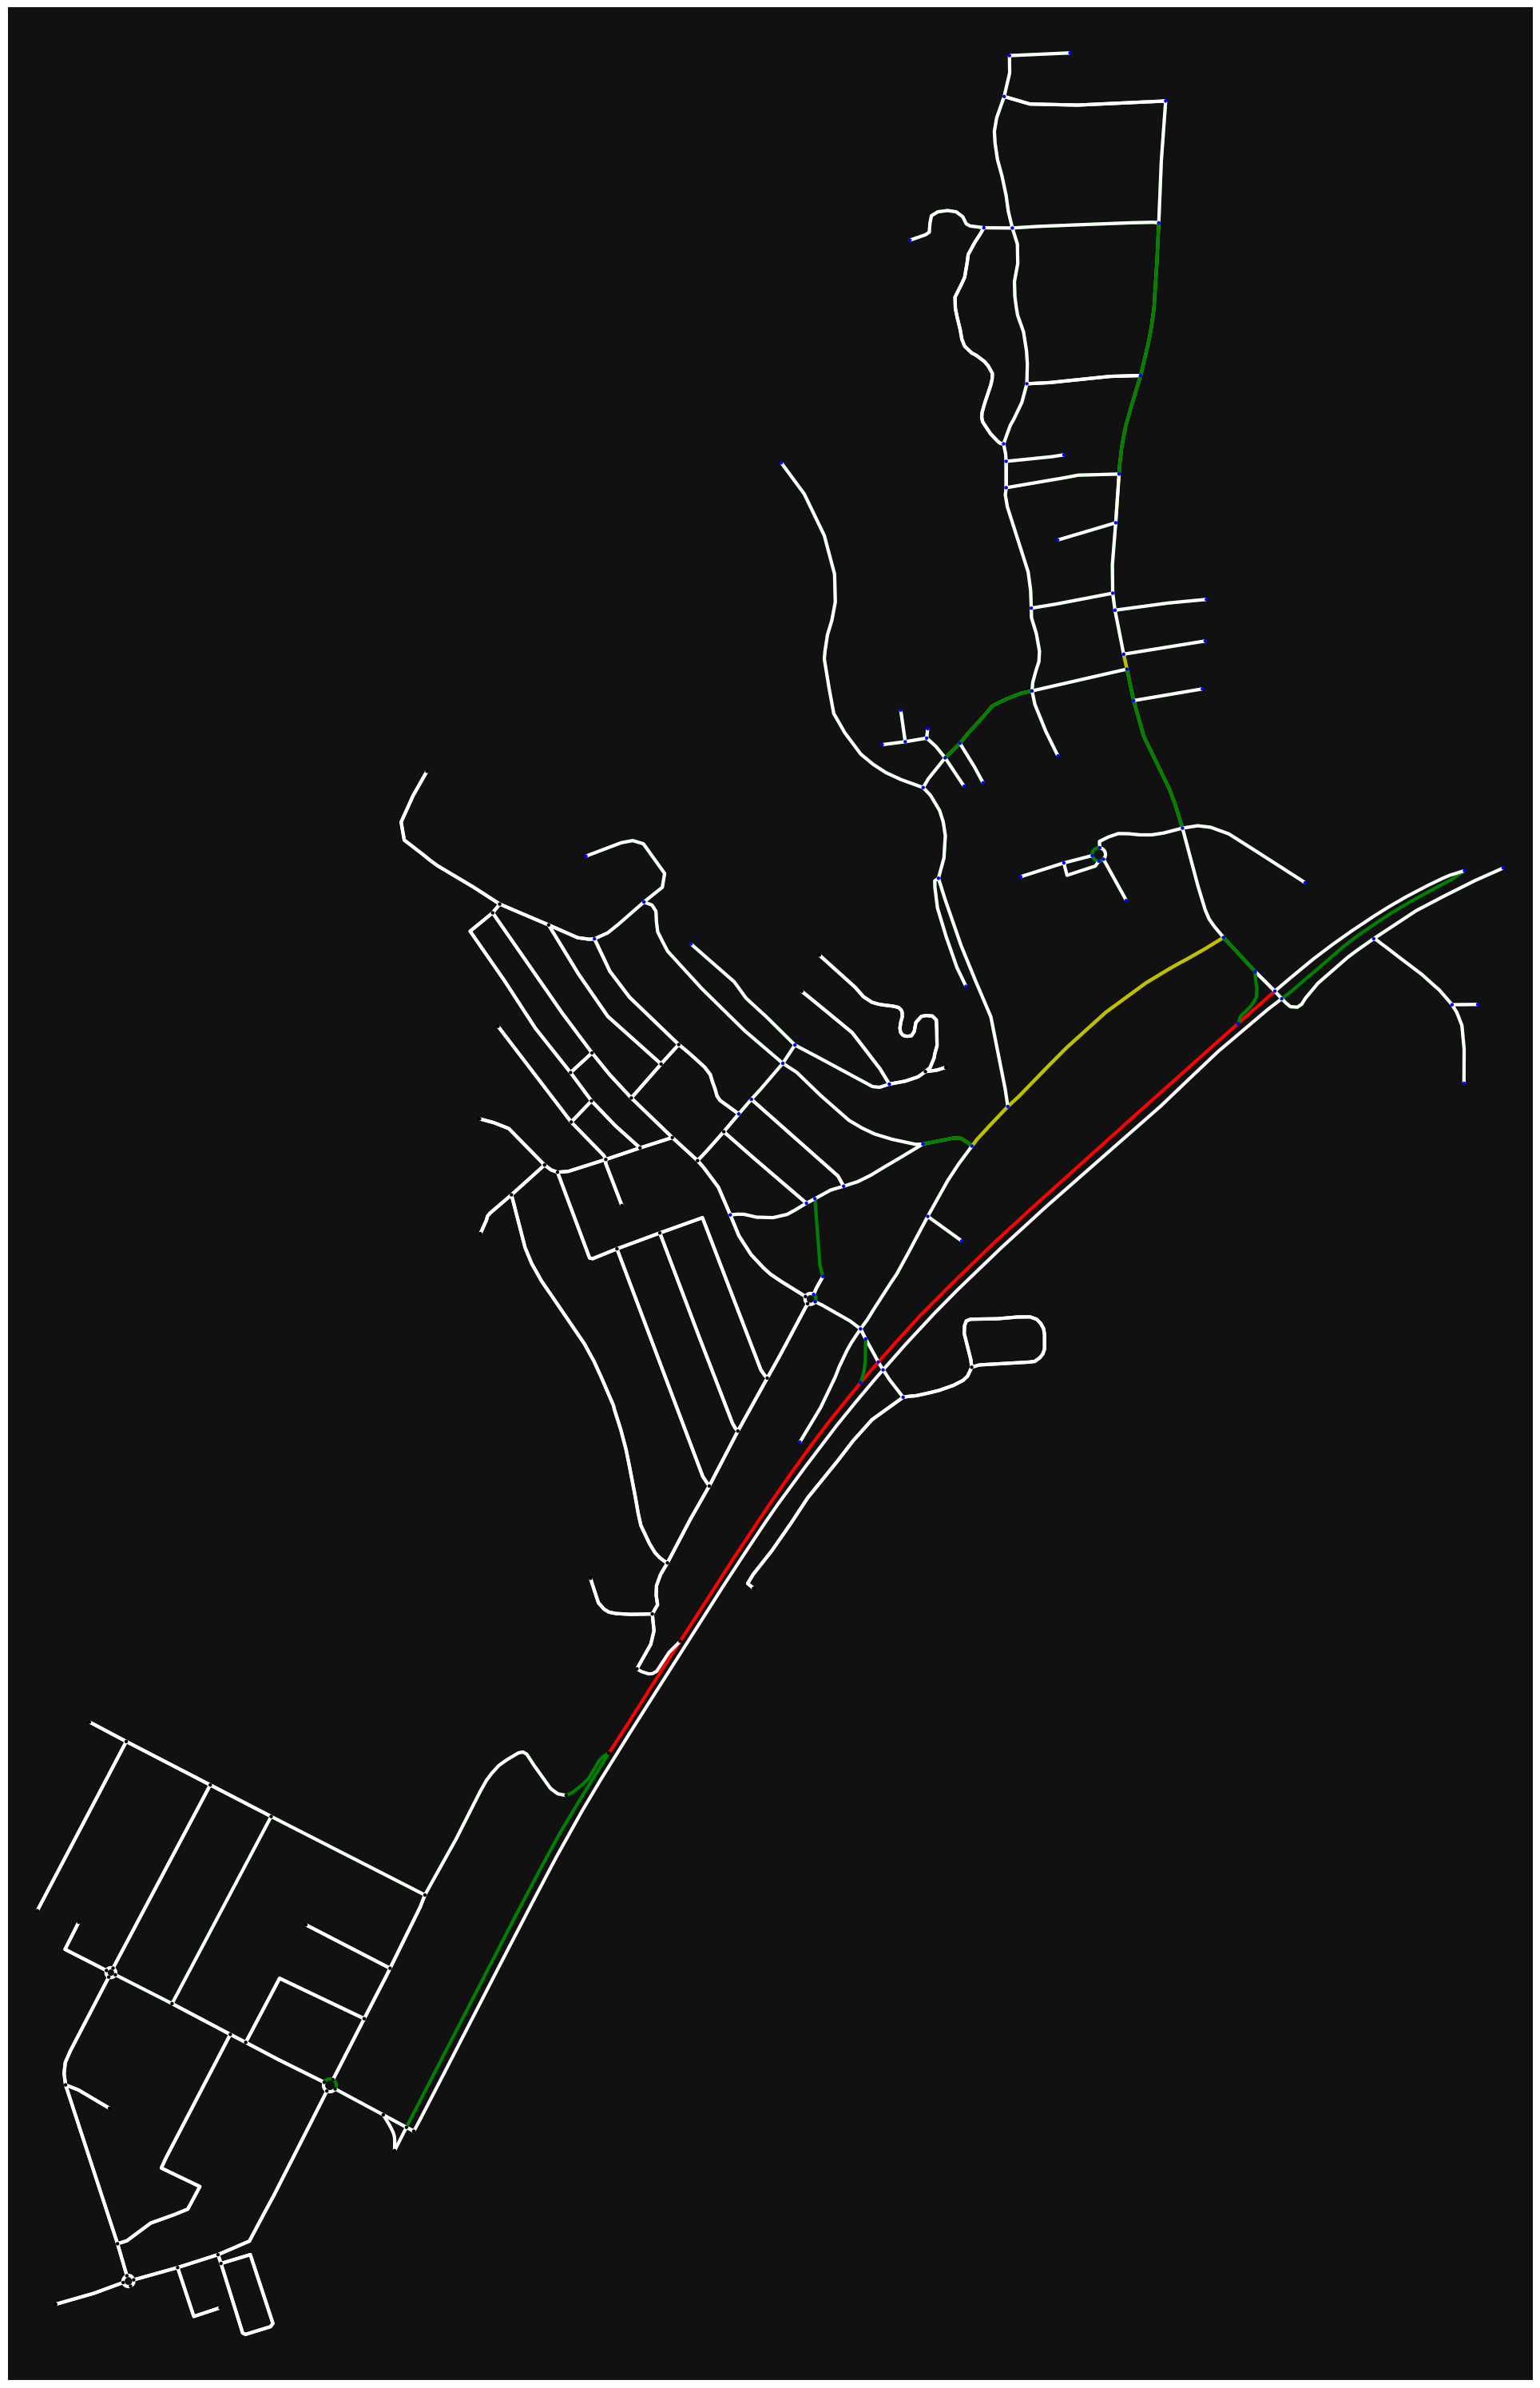

In [12]:
def najdi_pravi_edge(start, finish):
    counter = 0
    for i, row in edges.iterrows():
        if i[0] == start and i[1] == finish:
            return counter
        counter += 1
    
    
# analiziramo pretoke po cestah in jih shranimo v tabelo, tam kjer so umetno ločene dvosmerne ceste (v edges_list je artificial = True), bomo naredili
# vsoto pretoka v obeh smereh
edges_fluxes = [0] * len(G.edges)
# ker so reakcije oblike: Mx-intersection -> Mz, Mz -> My-intersection, moramo voditi evidenco, da ne bomo pretoka dodajali 2x
ze_dodano = [False] * len(G.edges)
ze_dodano_artificial = [False] * len(G.edges)
for reaction in model.reactions:
    # indeks metabolitov, ki niso intersection, je položaj ceste v edges_list
    try:
        r1 = reaction.reactants[0].id.split('-')[0].split('M')[1] 
        r1 = int(r1)
    except Exception:
        r1 = -1
    
    try:
        p1 = reaction.products[0].id.split('-')[0].split('M')[1]
        p1 = int(p1)
    except Exception:
        p1 = -1
    
    if r1 >= 0 and r1 < len(edges_list):
        target_u = edges_list[r1]['u']
        target_v = edges_list[r1]['v']
        if edges_list[r1]['artificial']:
            target_u = edges_list[r1]['v']
            target_v = edges_list[r1]['u']
        #print(edges_list[r1])
        indeks = najdi_pravi_edge(target_u, target_v)
        #print(indeks)
        #print(edges.iloc[indeks])
        #print('-----------------------------------')
        # dvosmerna cesta
        if edges_list[r1]['artificial'] and not ze_dodano_artificial[indeks]:
            edges_fluxes[indeks] += solution.fluxes[reaction.id]
            ze_dodano_artificial[indeks] = True
        else:
            if not ze_dodano[indeks]:
                edges_fluxes[indeks] = solution.fluxes[reaction.id]
                ze_dodano[indeks] = True
    elif p1 >= 0 and p1 < len(edges_list):
        target_u = edges_list[p1]['u']
        target_v = edges_list[p1]['v']
        if edges_list[p1]['artificial']:
            target_u = edges_list[p1]['v']
            target_v = edges_list[p1]['u']
        #print(edges_list[p1])
        indeks = najdi_pravi_edge(target_u, target_v)
        #print(edges.iloc[indeks])
        #print('-----------------------------------')
        # dvosmerna cesta
        if edges_list[p1]['artificial'] and not ze_dodano_artificial[indeks]:
            edges_fluxes[indeks] += solution.fluxes[reaction.id]
            ze_dodano_artificial[indeks] = True
        else:
            if not ze_dodano[indeks]:
                edges_fluxes[indeks] = solution.fluxes[reaction.id]
                ze_dodano[indeks] = True

# print(edges_fluxes)

barve = ['']*len(G.edges)
for i in range(len(G.edges)):
    if edges_fluxes[i] < 100:
        barve[i] = 'w'
    elif edges_fluxes[i] >= 100 and edges_fluxes[i] <= 2000:
        barve[i] = 'g'
    elif edges_fluxes[i] > 2000 and edges_fluxes[i] < 3500:
        barve[i] = 'y'
    else:
        barve[i] = 'r'
        
# reakcije uničevanja
barve_krizisc = []
for idx in range(len(G.nodes)):
    reac = model.reactions[idx]
    tmp = 'b' if solution.fluxes[reac.id] > 0 else 'k'
    barve_krizisc.append(tmp)

fig2, ax2 = ox.plot_graph(G, figsize=(58.33, 38.57), dpi=100, node_size=10, edge_color=barve, edge_linewidth=3, node_color=barve_krizisc)


In [137]:
for el in edges_list:
 el['geometry'] = list(el['geometry'].coords)

In [139]:
# za računanje povprečja koordinat
def average_coord(lst):
    x_coord = 0
    y_coord = 0
    for el in lst:
        x_coord += el[0]
        y_coord += el[1]
    x_coord /= len(lst)
    y_coord /= len(lst)
    return (x_coord, y_coord)

for el in edges_list:
    av = average_coord(el['geometry'])
    el['av_coord'] = av